# Imports, Configs and Datasets

In [1]:
import torch
from torch import nn, optim
import torchinfo # This library is used to get the summary of the model
import torchvision # This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [40]:
config = {
    'batch_size': 256, # Increase this if your GPU can handle it
    'epochs': 120,
    'initialized': False,
    'init_lr'       : 0.002,
    'weight_decay'  : 1e-5,
    'smoothing_factor': 0.1,
    'continue_training': True,
    'last_epoch': 53,
}

def init_config(model, notes=""):
    strict = True
    if not config['initialized']:
        config['model_name'] = f"{model.describe()}_{notes}"
        config['initialized'] = True
    else:
        if strict: raise Exception("Config already initialized")

In [3]:
from torchvision.transforms import v2

# Data paths
DATA_ROOT = "/mnt/e/Workspace/IDL/Data/hw2/11-785-s24-hw2p2-classification" # Local root for kaggle data
DATA_DIR    = DATA_ROOT 
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# --------------------------------------------------- #

# Transformations/augmentations of the Train dataset


train_transforms_plain = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ]) 

train_transforms_1 = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(15),
    # torchvision.transforms.ColorJitter(),
    # torchvision.transforms.RandomPerspective(),
    torchvision.transforms.ToTensor()
    ])

train_transforms_2 = v2.Compose([
    v2.RandomRotation(degrees=15),
    # v2.RandomResizedCrop(size=(224,224), antialias=True, scale=(0.8, 1.0)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToTensor(),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# --------------------------------------------------- #

# Transformations/augmentations of the Val dataset


valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) # TODO: Specify transformations performed on the val dataset

# --------------------------------------------------- #

# Initializing the train and val datasets

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms_1)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

# --------------------------------------------------- #

# Initializing the train and val dataloaders

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           num_workers = 8, # Uncomment this line if you want to increase your num workers
                                           pin_memory    = True)

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = False,
                                           num_workers = 4 # Uncomment this line if you want to increase your num workers
                                           )

/home/zzy/miniconda3/envs/11785/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [4]:
# --------------------------------------------------- #

# Test dataset class

class TestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# --------------------------------------------------- #

# Initializing the test dataset

"""
Why are we using val_transforms for Test Data?
"""

test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# --------------------------------------------------- #

# Initializing the test dataloader

test_loader = torch.utils.data.DataLoader(dataset    = test_dataset,
                                          batch_size = config['batch_size'],
                                          shuffle     = False,
                                          drop_last  = False,
                                          num_workers = 8 # Uncomment this line if you want to increase your num workers
                                          )

In [5]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

num_classes_train = len(train_dataset.classes)

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  256
Train batches        :  547
Val batches          :  137


torch.Size([256])


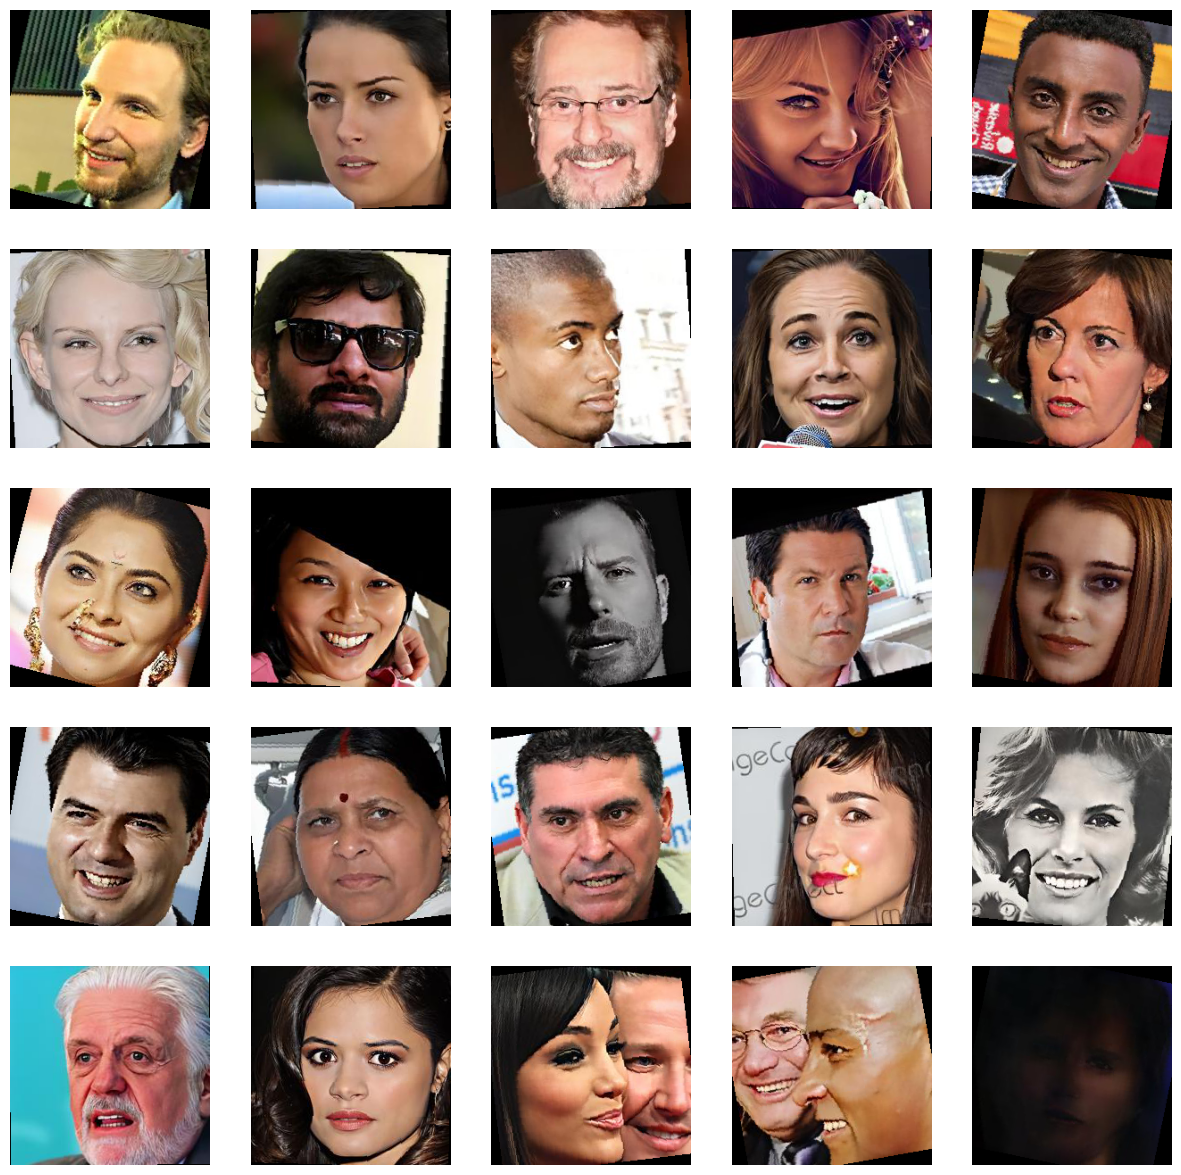

In [6]:
r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0

# dtl     = torch.utils.data.DataLoader(
#     dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms_1), # dont wanna see the images with transforms
#     batch_size  = config['batch_size'],
#     shuffle     = True)

for data in train_loader:
    x, y = data
    print(y.shape)

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

# del dtl

# Model Architectures

In [7]:
from torchvision import models
class TorchResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(pretrained=False)
        self.interm_features = self.model.fc.in_features
        self.model.fc = nn.Linear(self.interm_features, num_classes)
        self._init_weights()

    def forward(self, x, return_feats=False):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        x = self.model.avgpool(x)
        if return_feats:
            return x
        else :
            x = torch.flatten(x, 1)
            return self.model.fc(x)
    
    def describe(self):
        return "tResNet18"
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
  
    
# model = TorchResNet18(num_classes_train).to(DEVICE)
# torchinfo.summary(model, input_size=(config['batch_size'], 3, 224, 224))

In [17]:
from timm.models import ResNetV2

class TimmV2ResNet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = ResNetV2(
            layers=[2, 2 ,2, 2],
            num_classes=num_classes,
            global_pool='avg',
            drop_rate=0.1,
            drop_path_rate=0.1,
            act_layer = nn.Mish,
        )
    
    def forward(self, x, return_feats=False):
        x = self.model.forward_features(x)
        if return_feats:
            return x
        else:
            x = self.model.forward_head(x)
            return x
    
    def describe(self):
        return "tResNet18v2"

In [9]:
# class BottleNeck(nn.Module) = NotImplemented


# Traning and Validation
## classification loss, criterion, sched 

In [41]:
model = TimmV2ResNet18(num_classes_train).to(DEVICE)
init_config(model, "14M")

criterion = nn.CrossEntropyLoss(label_smoothing=config['smoothing_factor'])

optimizer = torch.optim.Adam(model.parameters(), lr= config['init_lr'], weight_decay=config['weight_decay'])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience=3, 
    min_lr=1e-8, 
    factor=0.2,
    verbose=True
)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=5e-8, verbose=True)

scaler = torch.cuda.amp.GradScaler()

print(criterion(torch.randn(1, num_classes_train, 10), torch.randint(0, num_classes_train, (1, 10))))
torchinfo.summary(model, input_size=(config['batch_size'], 3, 224, 224))

tensor(9.2399)


Layer (type:depth-idx)                                  Output Shape              Param #
TimmV2ResNet18                                          [256, 7001]               --
├─ResNetV2: 1-1                                         --                        --
│    └─Sequential: 2-1                                  [256, 64, 56, 56]         --
│    │    └─StdConv2d: 3-1                              [256, 64, 112, 112]       9,408
│    │    └─MaxPool2d: 3-2                              [256, 64, 56, 56]         --
│    └─Sequential: 2-2                                  [256, 2048, 7, 7]         --
│    │    └─ResNetStage: 3-3                            [256, 256, 56, 56]        144,512
│    │    └─ResNetStage: 3-4                            [256, 512, 28, 28]        657,920
│    │    └─ResNetStage: 3-5                            [256, 1024, 14, 14]       2,626,560
│    │    └─ResNetStage: 3-6                            [256, 2048, 7, 7]         10,496,000
│    └─GroupNormAct: 2-3        

## Classification

In [42]:
def train(model, dataloader, optimizer, criterion, logger, log_freq=100):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        if (i+1)%log_freq == 0:
                logger(i, total_loss / (i+1), num_correct * 100 / (config['batch_size'] * (i+1)))

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [43]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [44]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

## Verification Task

In [45]:
VER_ROOT = "/mnt/e/Workspace/IDL/Data/hw2/11-785-s24-hw2p2-verification"

# This obtains the list of known identities from the known folder
known_regex = f"{VER_ROOT}/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = f"{VER_ROOT}/unknown_dev/*"
unknown_test_regex = f"{VER_ROOT}/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 1231.45it/s]


In [46]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True).flatten(start_dim=1).unsqueeze(-1) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True).flatten(start_dim=1).unsqueeze(-1)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    #TODO: Why embeddings are 1-D?
    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats]).flatten(start_dim=1)
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    # threshold = # Choose a proper threshold
    # NO_CORRESPONDENCE_LABEL = 'n000000'
    # pred_id_strings = []
    # for idx, prediction in enumerate(predictions):
    #     if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
    #         pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
    #     else:
    #         pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv(f'{VER_ROOT}/verification_dev.csv')['label'].tolist()
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))
      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings


In [47]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Experiment
## Wandb

In [48]:
MODEL_ROOT = f"/mnt/e/Workspace/IDL/Models/hw2/11-785-s24-hw2p2-classification/{config['model_name']}"
if not os.path.exists(MODEL_ROOT):
    os.makedirs(MODEL_ROOT)

wandb.login(key="a07bacf1f6490c2d1a0d4e22dd08701319310f93") 


run = wandb.init(
        name    = config['model_name'], ### Wandb creates random run names if you skip this field, we recommend you give useful names
        reinit  = True, ### Allows reinitalizing runs when you re-run this cell
        #id     = "y28t31uz", ### Insert specific run id here if you want to resume a previous run
        #resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
        project = "hw2p2", ### Project should be created in your wandb account
        config  = config, ### Wandb Config for your run
        dir = MODEL_ROOT ### Wandb local directory
    )

# ### Save your model architecture as a string with str(model)
model_arch  = str(model)

# ### Save it in a txt file
arch_file   = open(f"{MODEL_ROOT}/model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

# ### log it in your wandb run with wandb.save()
wandb.save(arch_file.name)

def wandb_logger(iter, loss, acc):
    wandb.log({"train_loss": loss, "train_acc": acc})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇█▇▇▇▇▇▇██▇█▇▇▇██
train_classification_acc,▁▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
train_classification_loss,█▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▅▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▂▁▁▂▂▁▁
val_classification_acc,▁▂▂▃▃▄▄▅▄▅▅▅▅▆▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇██▇█▇█▇█▇██
val_classification_loss,█▇▇▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁
val_verification_acc,▂▁▂▃▃▃▄▄▅▅▅▄▆▅▇▆▇█▇▆▆▇▇▇▇▇▆▇▇▇▇▆█▆▇▇█▆█▇
learning_rate,0.005
train_acc,84.91211
train_classification_acc,82.03696


## Training

In [49]:
torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")


best_class_acc      = 0.0
best_ver_acc        = 0.0

#Continue training
if config.get('continue_training', False):
    last_epoch = config['last_epoch']
    model.load_state_dict(torch.load(f"{MODEL_ROOT}/model_{last_epoch}.pth"))
    initial_epoch = last_epoch + 1
    print(f"Loaded model from epoch {last_epoch}")
    scheduler.last_epoch = initial_epoch
else:
    initial_epoch = 0

for epoch in range(config['epochs']):
    if epoch < initial_epoch:
        continue
    
    # ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
    #                                              model, similarity_metric, config['batch_size'], mode='val')

    # print("\nEpoch {}/{}".format(epoch+1, config['epochs']))
    # raise Exception("Stop here")

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion, wandb_logger) # TODO: What function would you want implement here

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion) # TODO: What function would you want implement here
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))
    
    scheduler.step(val_loss)
    # scheduler.step()

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    
    torch.save(model.state_dict(), f'{MODEL_ROOT}/model_{epoch}.pth')
    
    if val_acc >= best_class_acc:
        best_class_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, f'{MODEL_ROOT}/checkpoint_classification.pth')
        wandb.save('checkpoint_verification.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, f'{MODEL_ROOT}/checkpoint_verification.pth')
      wandb.save('checkpoint_verification.pth')
      print("Saved verification model")

### Finish your wandb run
run.finish()

Loaded model from epoch 53



Epoch 55/120: 
Train Acc (Classification) 87.5943%	 Train Loss (Classification) 2.1826	 Learning Rate 0.0020


Val Acc (Classification) 78.3360%	 Val Loss (Classification) 2.7186


Val Acc (Verification) 34.7222%	 
Saved best classification model
Saved verification model



Epoch 56/120: 
Train Acc (Classification) 89.9080%	 Train Loss (Classification) 2.0854	 Learning Rate 0.0020


Val Acc (Classification) 78.6810%	 Val Loss (Classification) 2.7205


Val Acc (Verification) 32.5000%	 
Saved best classification model



Epoch 57/120: 
Train Acc (Classification) 90.2951%	 Train Loss (Classification) 2.0654	 Learning Rate 0.0020


Val Acc (Classification) 78.3217%	 Val Loss (Classification) 2.7220


Val Acc (Verification) 34.4444%	 



Epoch 58/120: 
Train Acc (Classification) 90.5607%	 Train Loss (Classification) 2.0520	 Learning Rate 0.0020


Val Acc (Classification) 78.6867%	 Val Loss (Classification) 2.7256


Val Acc (Verification) 34.7222%	 
Saved best classification model
Saved verification model



Epoch 59/120: 
Train Acc (Classification) 90.7557%	 Train Loss (Classification) 2.0435	 Learning Rate 0.0020


Val Acc (Classification) 78.2875%	 Val Loss (Classification) 2.7524


Val Acc (Verification) 35.5556%	 
Epoch 00059: reducing learning rate of group 0 to 4.0000e-04.
Saved verification model



Epoch 60/120: 
Train Acc (Classification) 94.9347%	 Train Loss (Classification) 1.8671	 Learning Rate 0.0004


Val Acc (Classification) 81.1474%	 Val Loss (Classification) 2.6317


Val Acc (Verification) 36.1111%	 
Saved best classification model
Saved verification model



Epoch 61/120: 
Train Acc (Classification) 95.6674%	 Train Loss (Classification) 1.8338	 Learning Rate 0.0004


Val Acc (Classification) 81.2186%	 Val Loss (Classification) 2.6258


Val Acc (Verification) 37.5000%	 
Saved best classification model
Saved verification model



Epoch 62/120: 
Train Acc (Classification) 95.9445%	 Train Loss (Classification) 1.8233	 Learning Rate 0.0004


Val Acc (Classification) 81.3384%	 Val Loss (Classification) 2.6265


Val Acc (Verification) 35.5556%	 
Saved best classification model



Epoch 63/120: 
Train Acc (Classification) 96.1245%	 Train Loss (Classification) 1.8136	 Learning Rate 0.0004


Val Acc (Classification) 81.4068%	 Val Loss (Classification) 2.6197


Val Acc (Verification) 35.8333%	 
Saved best classification model



Epoch 64/120: 
Train Acc (Classification) 96.1045%	 Train Loss (Classification) 1.8099	 Learning Rate 0.0004


Val Acc (Classification) 81.4753%	 Val Loss (Classification) 2.6170


Val Acc (Verification) 37.2222%	 
Saved best classification model



Epoch 65/120: 
Train Acc (Classification) 96.1659%	 Train Loss (Classification) 1.8059	 Learning Rate 0.0004


Val Acc (Classification) 81.4353%	 Val Loss (Classification) 2.6235


Val Acc (Verification) 36.3889%	 



Epoch 66/120: 
Train Acc (Classification) 96.4001%	 Train Loss (Classification) 1.8006	 Learning Rate 0.0004


Val Acc (Classification) 81.5608%	 Val Loss (Classification) 2.6154


Val Acc (Verification) 38.8889%	 
Saved best classification model
Saved verification model



Epoch 67/120: 
Train Acc (Classification) 96.4751%	 Train Loss (Classification) 1.7962	 Learning Rate 0.0004


Val Acc (Classification) 81.4753%	 Val Loss (Classification) 2.6171


Val Acc (Verification) 35.2778%	 



Epoch 68/120: 
Train Acc (Classification) 96.5201%	 Train Loss (Classification) 1.7916	 Learning Rate 0.0004


Val Acc (Classification) 81.4467%	 Val Loss (Classification) 2.6184


Val Acc (Verification) 35.8333%	 



Epoch 69/120: 
Train Acc (Classification) 96.5686%	 Train Loss (Classification) 1.7889	 Learning Rate 0.0004


Val Acc (Classification) 81.6777%	 Val Loss (Classification) 2.6091


Val Acc (Verification) 36.6667%	 
Saved best classification model



Epoch 70/120: 
Train Acc (Classification) 96.6301%	 Train Loss (Classification) 1.7865	 Learning Rate 0.0004


Val Acc (Classification) 81.5152%	 Val Loss (Classification) 2.6131


Val Acc (Verification) 36.9444%	 



Epoch 71/120: 
Train Acc (Classification) 96.6650%	 Train Loss (Classification) 1.7838	 Learning Rate 0.0004


Val Acc (Classification) 81.6093%	 Val Loss (Classification) 2.6110


Val Acc (Verification) 38.0556%	 



Epoch 72/120: 
Train Acc (Classification) 96.8100%	 Train Loss (Classification) 1.7809	 Learning Rate 0.0004


Val Acc (Classification) 81.7433%	 Val Loss (Classification) 2.6085


Val Acc (Verification) 36.3889%	 
Saved best classification model



Epoch 73/120: 
Train Acc (Classification) 96.8457%	 Train Loss (Classification) 1.7747	 Learning Rate 0.0004


Val Acc (Classification) 81.6948%	 Val Loss (Classification) 2.6085


Val Acc (Verification) 36.1111%	 



Epoch 74/120: 
Train Acc (Classification) 96.8707%	 Train Loss (Classification) 1.7752	 Learning Rate 0.0004


Val Acc (Classification) 81.6150%	 Val Loss (Classification) 2.6141


Val Acc (Verification) 36.1111%	 



Epoch 75/120: 
Train Acc (Classification) 96.8229%	 Train Loss (Classification) 1.7728	 Learning Rate 0.0004


Val Acc (Classification) 81.6207%	 Val Loss (Classification) 2.6096


Val Acc (Verification) 38.8889%	 
Saved verification model



Epoch 76/120: 
Train Acc (Classification) 96.9586%	 Train Loss (Classification) 1.7687	 Learning Rate 0.0004


Val Acc (Classification) 81.5608%	 Val Loss (Classification) 2.6081


Val Acc (Verification) 37.7778%	 



Epoch 77/120: 
Train Acc (Classification) 96.9607%	 Train Loss (Classification) 1.7689	 Learning Rate 0.0004


Val Acc (Classification) 81.6292%	 Val Loss (Classification) 2.6099


Val Acc (Verification) 37.7778%	 



Epoch 78/120: 
Train Acc (Classification) 97.0542%	 Train Loss (Classification) 1.7653	 Learning Rate 0.0004


Val Acc (Classification) 81.7262%	 Val Loss (Classification) 2.6019


Val Acc (Verification) 37.5000%	 



Epoch 79/120: 
Train Acc (Classification) 97.0664%	 Train Loss (Classification) 1.7617	 Learning Rate 0.0004


Val Acc (Classification) 81.6235%	 Val Loss (Classification) 2.6026


Val Acc (Verification) 38.0556%	 



Epoch 80/120: 
Train Acc (Classification) 97.1299%	 Train Loss (Classification) 1.7600	 Learning Rate 0.0004


Val Acc (Classification) 81.6121%	 Val Loss (Classification) 2.6028


Val Acc (Verification) 36.3889%	 



Epoch 81/120: 
Train Acc (Classification) 97.1778%	 Train Loss (Classification) 1.7596	 Learning Rate 0.0004


Val Acc (Classification) 81.8830%	 Val Loss (Classification) 2.6057


Val Acc (Verification) 37.2222%	 
Saved best classification model



Epoch 82/120: 
Train Acc (Classification) 97.1735%	 Train Loss (Classification) 1.7575	 Learning Rate 0.0004


Val Acc (Classification) 81.7917%	 Val Loss (Classification) 2.6044


Val Acc (Verification) 36.9444%	 
Epoch 00082: reducing learning rate of group 0 to 8.0000e-05.



Epoch 83/120: 
Train Acc (Classification) 97.7962%	 Train Loss (Classification) 1.7231	 Learning Rate 0.0001


Val Acc (Classification) 82.2993%	 Val Loss (Classification) 2.5755


Val Acc (Verification) 37.5000%	 
Saved best classification model



Epoch 84/120: 
Train Acc (Classification) 97.9640%	 Train Loss (Classification) 1.7132	 Learning Rate 0.0001


Val Acc (Classification) 82.4133%	 Val Loss (Classification) 2.5713


Val Acc (Verification) 37.7778%	 
Saved best classification model



Epoch 85/120: 
Train Acc (Classification) 97.9697%	 Train Loss (Classification) 1.7113	 Learning Rate 0.0001


Val Acc (Classification) 82.3934%	 Val Loss (Classification) 2.5730


Val Acc (Verification) 37.5000%	 



Epoch 86/120: 
Train Acc (Classification) 97.9612%	 Train Loss (Classification) 1.7111	 Learning Rate 0.0001


Val Acc (Classification) 82.4390%	 Val Loss (Classification) 2.5694


Val Acc (Verification) 37.2222%	 
Saved best classification model



Epoch 87/120: 
Train Acc (Classification) 98.0397%	 Train Loss (Classification) 1.7075	 Learning Rate 0.0001


Val Acc (Classification) 82.4703%	 Val Loss (Classification) 2.5679


Val Acc (Verification) 38.3333%	 
Saved best classification model



Epoch 88/120: 
Train Acc (Classification) 98.0790%	 Train Loss (Classification) 1.7066	 Learning Rate 0.0001


Val Acc (Classification) 82.4789%	 Val Loss (Classification) 2.5692


Val Acc (Verification) 38.3333%	 
Saved best classification model



Epoch 89/120: 
Train Acc (Classification) 98.0526%	 Train Loss (Classification) 1.7068	 Learning Rate 0.0001


Val Acc (Classification) 82.5359%	 Val Loss (Classification) 2.5658


Val Acc (Verification) 37.7778%	 
Saved best classification model



Epoch 90/120: 
Train Acc (Classification) 98.1161%	 Train Loss (Classification) 1.7020	 Learning Rate 0.0001


Val Acc (Classification) 82.5074%	 Val Loss (Classification) 2.5653


Val Acc (Verification) 37.7778%	 



Epoch 91/120: 
Train Acc (Classification) 98.0647%	 Train Loss (Classification) 1.7041	 Learning Rate 0.0001


Val Acc (Classification) 82.5188%	 Val Loss (Classification) 2.5639


Val Acc (Verification) 38.6111%	 



Epoch 92/120: 
Train Acc (Classification) 98.0983%	 Train Loss (Classification) 1.7036	 Learning Rate 0.0001


Val Acc (Classification) 82.5559%	 Val Loss (Classification) 2.5629


Val Acc (Verification) 38.8889%	 
Saved best classification model
Saved verification model



Epoch 93/120: 
Train Acc (Classification) 98.1304%	 Train Loss (Classification) 1.7001	 Learning Rate 0.0001


Val Acc (Classification) 82.5217%	 Val Loss (Classification) 2.5638


Val Acc (Verification) 39.1667%	 
Saved verification model



Epoch 94/120: 
Train Acc (Classification) 98.0826%	 Train Loss (Classification) 1.7009	 Learning Rate 0.0001


Val Acc (Classification) 82.5673%	 Val Loss (Classification) 2.5635


Val Acc (Verification) 37.2222%	 
Saved best classification model



Epoch 95/120: 
Train Acc (Classification) 98.1133%	 Train Loss (Classification) 1.7003	 Learning Rate 0.0001


Val Acc (Classification) 82.6528%	 Val Loss (Classification) 2.5591


Val Acc (Verification) 38.6111%	 
Saved best classification model



Epoch 96/120: 
Train Acc (Classification) 98.1219%	 Train Loss (Classification) 1.6999	 Learning Rate 0.0001


Val Acc (Classification) 82.5815%	 Val Loss (Classification) 2.5590


Val Acc (Verification) 37.5000%	 



Epoch 97/120: 
Train Acc (Classification) 98.2126%	 Train Loss (Classification) 1.6975	 Learning Rate 0.0001


Val Acc (Classification) 82.5815%	 Val Loss (Classification) 2.5604


Val Acc (Verification) 38.6111%	 



Epoch 98/120: 
Train Acc (Classification) 98.1797%	 Train Loss (Classification) 1.6968	 Learning Rate 0.0001


Val Acc (Classification) 82.7612%	 Val Loss (Classification) 2.5591


Val Acc (Verification) 38.0556%	 
Saved best classification model



Epoch 99/120: 
Train Acc (Classification) 98.1454%	 Train Loss (Classification) 1.6981	 Learning Rate 0.0001


Val Acc (Classification) 82.6842%	 Val Loss (Classification) 2.5554


Val Acc (Verification) 37.7778%	 



Epoch 100/120: 
Train Acc (Classification) 98.2190%	 Train Loss (Classification) 1.6959	 Learning Rate 0.0001


Val Acc (Classification) 82.6842%	 Val Loss (Classification) 2.5566


Val Acc (Verification) 38.3333%	 



Epoch 101/120: 
Train Acc (Classification) 98.1918%	 Train Loss (Classification) 1.6953	 Learning Rate 0.0001


Val Acc (Classification) 82.6585%	 Val Loss (Classification) 2.5570


Val Acc (Verification) 37.7778%	 



Epoch 102/120: 
Train Acc (Classification) 98.2340%	 Train Loss (Classification) 1.6948	 Learning Rate 0.0001


Val Acc (Classification) 82.6443%	 Val Loss (Classification) 2.5579


Val Acc (Verification) 38.6111%	 



Epoch 103/120: 
Train Acc (Classification) 98.2490%	 Train Loss (Classification) 1.6915	 Learning Rate 0.0001


Val Acc (Classification) 82.7412%	 Val Loss (Classification) 2.5520


Val Acc (Verification) 36.6667%	 



Epoch 104/120: 
Train Acc (Classification) 98.1890%	 Train Loss (Classification) 1.6947	 Learning Rate 0.0001


Val Acc (Classification) 82.6500%	 Val Loss (Classification) 2.5540


Val Acc (Verification) 38.0556%	 



Epoch 105/120: 
Train Acc (Classification) 98.2097%	 Train Loss (Classification) 1.6925	 Learning Rate 0.0001


Val Acc (Classification) 82.7013%	 Val Loss (Classification) 2.5565


Val Acc (Verification) 38.8889%	 



Epoch 106/120: 
Train Acc (Classification) 98.2268%	 Train Loss (Classification) 1.6920	 Learning Rate 0.0001


Val Acc (Classification) 82.7526%	 Val Loss (Classification) 2.5553


Val Acc (Verification) 38.3333%	 



Epoch 107/120: 
Train Acc (Classification) 98.2775%	 Train Loss (Classification) 1.6905	 Learning Rate 0.0001


Val Acc (Classification) 82.6072%	 Val Loss (Classification) 2.5570


Val Acc (Verification) 37.2222%	 
Epoch 00107: reducing learning rate of group 0 to 1.6000e-05.



Epoch 108/120: 
Train Acc (Classification) 98.3639%	 Train Loss (Classification) 1.6855	 Learning Rate 0.0000


Val Acc (Classification) 82.7412%	 Val Loss (Classification) 2.5519


Val Acc (Verification) 38.6111%	 



Epoch 109/120: 
Train Acc (Classification) 98.3747%	 Train Loss (Classification) 1.6823	 Learning Rate 0.0000


Val Acc (Classification) 82.7612%	 Val Loss (Classification) 2.5504


Val Acc (Verification) 38.0556%	 
Saved best classification model



Epoch 110/120: 
Train Acc (Classification) 98.3625%	 Train Loss (Classification) 1.6831	 Learning Rate 0.0000


Val Acc (Classification) 82.8410%	 Val Loss (Classification) 2.5472


Val Acc (Verification) 37.5000%	 
Saved best classification model



Epoch 111/120: 
Train Acc (Classification) 98.3539%	 Train Loss (Classification) 1.6832	 Learning Rate 0.0000


Val Acc (Classification) 82.8695%	 Val Loss (Classification) 2.5475


Val Acc (Verification) 38.3333%	 
Saved best classification model



Epoch 112/120: 
Train Acc (Classification) 98.3775%	 Train Loss (Classification) 1.6824	 Learning Rate 0.0000


Val Acc (Classification) 82.7982%	 Val Loss (Classification) 2.5492


Val Acc (Verification) 38.3333%	 



Epoch 113/120: 
Train Acc (Classification) 98.3539%	 Train Loss (Classification) 1.6822	 Learning Rate 0.0000


Val Acc (Classification) 82.8895%	 Val Loss (Classification) 2.5469


Val Acc (Verification) 38.0556%	 
Saved best classification model



Epoch 114/120: 
Train Acc (Classification) 98.3882%	 Train Loss (Classification) 1.6799	 Learning Rate 0.0000


Val Acc (Classification) 82.8553%	 Val Loss (Classification) 2.5492


Val Acc (Verification) 37.7778%	 



Epoch 115/120: 
Train Acc (Classification) 98.4082%	 Train Loss (Classification) 1.6800	 Learning Rate 0.0000


Val Acc (Classification) 82.8325%	 Val Loss (Classification) 2.5469


Val Acc (Verification) 38.0556%	 



Epoch 116/120: 
Train Acc (Classification) 98.4446%	 Train Loss (Classification) 1.6782	 Learning Rate 0.0000


Val Acc (Classification) 82.8154%	 Val Loss (Classification) 2.5473


Val Acc (Verification) 38.8889%	 



Epoch 117/120: 
Train Acc (Classification) 98.4525%	 Train Loss (Classification) 1.6797	 Learning Rate 0.0000


Val Acc (Classification) 82.8553%	 Val Loss (Classification) 2.5470


Val Acc (Verification) 38.6111%	 
Epoch 00117: reducing learning rate of group 0 to 3.2000e-06.



Epoch 118/120: 
Train Acc (Classification) 98.4089%	 Train Loss (Classification) 1.6791	 Learning Rate 0.0000


Val Acc (Classification) 82.8496%	 Val Loss (Classification) 2.5474


Val Acc (Verification) 38.3333%	 



Epoch 119/120: 
Train Acc (Classification) 98.3875%	 Train Loss (Classification) 1.6781	 Learning Rate 0.0000


Val Acc (Classification) 82.8439%	 Val Loss (Classification) 2.5473


Val Acc (Verification) 38.3333%	 



Epoch 120/120: 
Train Acc (Classification) 98.4168%	 Train Loss (Classification) 1.6796	 Learning Rate 0.0000


Val Acc (Classification) 82.8439%	 Val Loss (Classification) 2.5463


Val Acc (Verification) 38.3333%	 


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


learning_rate,███▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▃▃▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
train_classification_acc,▁▂▃▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
train_classification_loss,█▇▆▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_classification_acc,▁▂▂▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇████████████████
val_classification_loss,███▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_verification_acc,▃▁▃▅▆▄▅█▄▆▇▅█▇▆▅▆▆▆▆▇▇▇█▇▆▇▇▇▅█▇▇▆▇▇▇█▇▇
learning_rate,0.0
train_acc,98.44219
train_classification_acc,98.41679


# Testing and Kaggle Submission

In [54]:
tmp = torch.load(f"{MODEL_ROOT}/checkpoint_verification.pth")
model.load_state_dict(tmp['model_state_dict'])

<All keys matched successfully>

In [55]:
def test(model,dataloader): # TODO: Run to finish predicting on the test set.

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [56]:
test_results = test(model, test_loader)

In [57]:
pred_id_strings = eval_verification(unknown_test_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='test')

In [58]:
# TODO: Run to write the results in the files and submit to Kaggle
# You only have 10 Kaggle submissions per day


with open("./classification_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open("./verification_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))